In [10]:
import os
from fnmatch import fnmatch

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import fitsio

from astropy.io import fits
from astropy.table import Table

import treecorr

In [2]:
source_cat = treecorr.Catalog('/data2/lsajkov/mpdg/data/KiDS/KiDS_DR4.1_ugriZYJHKs_SOM_gold_WL_cat.fits',
                              ra_col = 'RAJ2000', dec_col = 'DECJ2000',
                              ra_units = 'degrees', dec_units = 'degrees',
                              g1_col = 'e1', g2_col = 'e2',)
                            #   w = 'weight')

In [3]:
lens_cat = treecorr.Catalog('/data2/lsajkov/mpdg/data_products/predicted_catalogs/KiDS_SOM_predicted_31Jul24.fits',
                            ra_col = 'ra', dec_col = 'dec',
                            ra_units = 'degrees', dec_units = 'degrees',
                            )

In [14]:
config = {'nbins':    10,
          'bin_size': 1,
          'min_sep': 2.5,
          'sep_units': 'arcsec',}

In [15]:
ngc = treecorr.NGCorrelation(config = config)

In [16]:
ngc.process(lens_cat, source_cat)

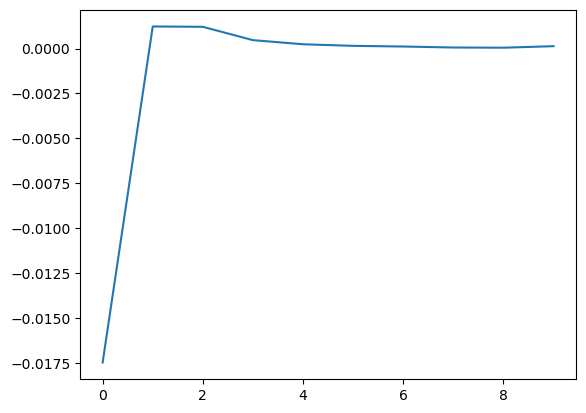

In [13]:
plt.plot(ngc.xi)

In [3]:
cat.write('/data2/lsajkov/mpdg/data_products/KiDS/WL/KiDS_WL_30Jul24.fits')

['ra', 'dec', 'g1', 'g2']

In [12]:
Table(fitsio.read('/data2/lsajkov/mpdg/data/KiDS/KiDS_SOM_gold_WL_ord2cut.fits', ext = 1))

SeqNr,SLID,SID,ID,FLUX_AUTO,FLUXERR_AUTO,MAG_AUTO,MAGERR_AUTO,KRON_RADIUS,BackGr,Level,MU_THRESHOLD,MaxVal,MU_MAX,ISOAREA_WORLD,Xpos,Ypos,RAJ2000,DECJ2000,A_WORLD,B_WORLD,THETA_J2000,THETA_WORLD,ERRA_WORLD,ERRB_WORLD,ERRTHETA_J2000,ERRTHETA_WORLD,FWHM_IMAGE,FWHM_WORLD,Flag,FLUX_RADIUS,CLASS_STAR,EXTINCTION_u,EXTINCTION_g,EXTINCTION_r,EXTINCTION_i,PAgaap,MAG_ISO,MAGERR_ISO,FLUX_ISO,FLUXERR_ISO,MAG_ISOCOR,MAGERR_ISOCOR,FLUX_ISOCOR,FLUXERR_ISOCOR,NIMAFLAGS_ISO,IMAFLAGS_ISO,XMIN_IMAGE,YMIN_IMAGE,XMAX_IMAGE,YMAX_IMAGE,X_WORLD,Y_WORLD,X2_WORLD,Y2_WORLD,XY_WORLD,ERRX2_WORLD,ERRY2_WORLD,ERRXY_WORLD,CXX_WORLD,CYY_WORLD,CXY_WORLD,ERRCXX_WORLD,ERRCYY_WORLD,ERRCXY_WORLD,A_IMAGE,B_IMAGE,ERRA_IMAGE,ERRB_IMAGE,S_ELLIPTICITY,S_ELONGATION,ALPHA_J2000,DELTA_J2000,SG2DPHOT,HTM,FIELD_POS,EXTINCTION_Z,EXTINCTION_Y,EXTINCTION_J,EXTINCTION_H,EXTINCTION_Ks,MAG_GAAP_u,MAGERR_GAAP_u,FLUX_GAAP_u,FLUXERR_GAAP_u,FLAG_GAAP_u,MAG_GAAP_g,MAGERR_GAAP_g,FLUX_GAAP_g,FLUXERR_GAAP_g,FLAG_GAAP_g,MAG_GAAP_r,MAGERR_GAAP_r,FLUX_GAAP_r,FLUXERR_GAAP_r,FLAG_GAAP_r,MAG_GAAP_i,MAGERR_GAAP_i,FLUX_GAAP_i,FLUXERR_GAAP_i,FLAG_GAAP_i,MAG_GAAP_Z,MAGERR_GAAP_Z,FLUX_GAAP_Z,FLUXERR_GAAP_Z,FLAG_GAAP_Z,MAG_GAAP_Y,MAGERR_GAAP_Y,FLUX_GAAP_Y,FLUXERR_GAAP_Y,FLAG_GAAP_Y,MAG_GAAP_J,MAGERR_GAAP_J,FLUX_GAAP_J,FLUXERR_GAAP_J,FLAG_GAAP_J,MAG_GAAP_H,MAGERR_GAAP_H,FLUX_GAAP_H,FLUXERR_GAAP_H,FLAG_GAAP_H,MAG_GAAP_Ks,MAGERR_GAAP_Ks,FLUX_GAAP_Ks,FLUXERR_GAAP_Ks,FLAG_GAAP_Ks,Agaper,Bgaper,MAG_LIM_u,MAG_LIM_g,MAG_LIM_r,MAG_LIM_i,MAG_LIM_Z,MAG_LIM_Y,MAG_LIM_J,MAG_LIM_H,MAG_LIM_Ks,Z_B,Z_B_MIN,Z_B_MAX,T_B,ODDS,Z_ML,T_ML,CHI_SQUARED_BPZ,M_0,BPZ_FILT,NBPZ_FILT,BPZ_NONDETFILT,NBPZ_NONDETFILT,BPZ_FLAGFILT,NBPZ_FLAGFILT,SG_FLAG,MASK,THELI_NAME,fitclass,bias_corrected_scalelength_pixels,bulge_fraction,model_flux,pixel_SNratio,model_SNratio,contamination_radius,PSF_e1,PSF_e2,PSF_Strehl_ratio,PSF_Q11,PSF_Q22,PSF_Q12,star_galaxy_f_probability,r_correction,2D_measurement_variance,mean_likelihood_e,neighbour_mag,neighbour_distance,catmag,n_exposures_used,cat_ID,delta_SNR,PSF_e1_exp1,PSF_e2_exp1,PSF_e1_exp2,PSF_e2_exp2,PSF_e1_exp3,PSF_e2_exp3,PSF_e1_exp4,PSF_e2_exp4,PSF_e1_exp5,PSF_e2_exp5,SeqNr_field,THELI_INT,e1,e2,weight
int32,int32,int32,str25,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float64,float64,int16,int32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int16,float32,float32,float32,float32,int16,float32,float32,float32,float32,int16,float32,float32,float32,float32,int16,float32,float32,float32,float32,int16,float32,float32,float32,float32,int16,float32,float32,float32,float32,int16,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,int32,int32,int32,float32,int32,str16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int16,float32,float32,float32
100,55067781,29523,KIDS_J083849.64+020957.1,7.400736,0.3035208,22.49681,0.0445393,3.5,-0.0001101333,0.02926305,24.97979,0.1702185,23.24455,3.074269e-07,5341.935,4879.624,129.706829,2.165873,0.0001736353,0.0001214457,23.72997,66.27003,6.714446e-06,4.738574e-06,21.50592,68.49408,11.22332,0.000667164,0,3.536133,0.0003063516,0.2135496,0.1663964,0.1151123

In [ ]:
treecorr.Catalog(ra_col = wl_cat['RAJ2000'], dec_col = wl_cat['DECJ2000'],
                 ra_units = 'degrees', dec_units = 'degrees',
                 g1_col = wl_cat['e1'], g2_col = wl_cat['e2'],
                 w = wl_cat[''])

In [ ]:
wl_cat['RAJ2000']